# **Laboratorio 5 - Problemas de Optimización Multiobjetivo**

**Estudiantes:**

Santiago Jaimes Puerto - 201921921\
Nicolás Rincón Sánchez - 202021963

---


# Instrucciones de Ejecución

El siguiente notebook de Jupyter contiene el código que utiliza la librería `Pyomo` para resolver los modelos de optimización matemática planteados para este laboratorio. Para ejecutarlo, basta con cargar el archivo a Google Collab y ejecutar todas las celdas. Así mismo, es posible correr el cuaderno desde un IDE local (como VS Code, por ejemplo) siguiendo el mismo procedimiento, siempre y cuando se ajuste el kernel a un entorno que tenga instalados `pyomo` y `glpk`.

# Instalación de Librerías (Google Collab)

Esta celda se debe ejecutar obligatoriamente si se realiza la ejecución desde Google Collab. De lo contrario, puede ser ignorada.

In [1]:
## Tip: Please put code like this at the top of your notebook.
# We want all of the module/package installations to start up front

import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py"
    import helper
    helper.install_idaes()
    helper.install_ipopt()
    helper.install_glpk()

# Problema \#1 - Distribución óptima de recursos en una misión humanitaria

## 1.1 Descripción del Problema

Este ejercicio plantea la distribución óptima de recursos esenciales para una misión humanitaria en Zambia. Se dispone de una flota de aviones para transportar diversos recursos a diferentes zonas afectadas. El problema tiene dos objetivos: maximizar el valor de impacto social de los recursos transportados y minimizar el costo total de las operaciones logísticas.

Las funciones objetivo se calculan como:

$$Z_1 = \sum_{i\in\text{Recursos}}\sum_{j\in\text{Aviones}}\sum_{v\in\text{Viajes}}\sum_{k\in\text{Zonas}}\text{Valor Impacto}_i \times \text{Cantidad}_{ijvk} \times \text{Multiplicador Impacto}_k$$

$$Z_2 = \sum_{j\in\text{Aviones}} \text{Costo Fijo}_j \times \text{UsaAvión}_j + \sum_{j\in\text{Aviones}}\sum_{v\in\text{Viajes}}\sum_{k\in\text{Zonas}} \text{Costo Variable}_j \times \text{Distancia}_k \times \text{AsignaciónZona}_{jvk}$$

Teniendo en cuenta la descripción de los datos del problema a continuación.

## 1.2 Datos del Problema

### Tabla 1: Características de cada recurso
| **Recurso**         |**Valor de Impacto (miles USD/TON)** |**Peso (TON/ud)** |**Volumen (m³/ud)** |**Disponibilidad (ud)**|
|---------------------|----------|---------------|-----------------|-----|
| Alimentos Básicos   | 50       | 5             | 3               | 12  |
| Medicinas           | 100      | 2             | 1               | 15  |
| Equipos Médicos     | 120      | 0.3           | 0.5             | 40  |
| Agua Potable        | 60       | 6             | 4               | 15  |
| Mantas              | 40       | 3             | 2               | 20  |


### Tabla 2: Capacidades de cada avión
| **Avión** | **Capacidad (TON)** | **Capacidad (m³)** | **Costo Fijo (miles USD)** | **Costo Variable (miles USD/km)**
|-----------|---------------------|--------------------|----|-------|
| 1         | 40                  | 35                 |15  | 0.020 |
| 2         | 50                  | 40                 |20  | 0.025 |
| 3         | 60                  | 45                 |25  | 0.030 |
| 4         | 45                  | 38                 |18  | 0.022 |


### Tabla 3: Características de las zonas de destino
| **Zona** | **Distancia (km)** | **Población (miles)** | **Multiplicador** |
|----------|--------------------|-----------------------|-------------------|
| A        | 800                | 50                    | 1.2               |
| B        | 1200               | 70                    | 1.5               |
| C        | 1500               | 100                   | 1.8               |
| D        | 900                | 80                    | 1.4               |


### Tabla 4: Necesidades mínimas por zona y tipo de recurso
| **Zona** | **Alimentos (TON)** | **Agua (TON)** | **Medicinas (TON)** | **Equipos (TON)** | **Mantas (TON)** |
|------|------|------|------|------|------|
| A    |  8   |  6   |  2   | 0.6  |  3   |
| B    |  12  |  9   |  3   | 0.9  |  5   |
| C    |  16  |  12  |  4   | 1.2  |  7   |
| D    |  10  |  8   |  2   | 0.6  |  4   |

\
Además, se deben considerar los siguientes puntos:

* **Necesidades mínimas obligatorias:** A diferencia de ejercicios anteriores, en este problema se <u>DEBE</u> cumplir al 100.
* **Entrega de recursos por encima del mínimo:** Se permite y se fomenta la
entrega de cantidades que excedan las necesidades mínimas, especialmente en zonas con mayor multiplicador de impacto, lo que aumentará el valor del impacto social total.
* **Equipos Médicos:** Son dispositivos indivisibles que pesan 300 kg (0.3 TON) cada uno. Deben transportarse en unidades completas.
* **Disponibilidad:** Indica el número máximo de unidades disponibles para transportar. Los valores de la tabla representan la disponibilidad total, no por zona.
* **Multiplicador de Impacto:** Factor que multiplica el valor de impacto social de los recursos cuando se entregan en una zona específica, reflejando la gravedad de la situación humanitaria. Zonas con mayor multiplicador tienen mayor prioridad desde la perspectiva del impacto social.

\
Se tienen las siguientes limitaciones logísticas:

* **Asignación de aviones:** Se dispone de 4 aviones para asegurar que todas las zonas puedan ser atendidas adecuadamente.
* **Capacidad de vuelos:** Cada avión puede realizar hasta 2 viajes a diferentes zonas, permitiendo flexibilidad en la distribución.
* **Seguridad de Medicamentos:** Las medicinas no podrán transportarse en el Avión 1 debido a la falta de sistemas de refrigeración adecuados.
* **Compatibilidad de recursos:** Los equipos médicos y el agua potable no pueden viajar en el mismo avión durante el mismo viaje para evitar contaminación cruzada. Esta incompatibilidad se aplica por viaje, no por avión, por lo que un avión podría transportar equipos médicos en un viaje y agua potable en otro.
* **División de recursos:** Todos los recursos pueden dividirse y transportarse en fracciones, excepto los equipos médicos que son dispositivos indivisibles de 300 kg cada uno (deben enviarse como unidades completas).
* **Zona por viaje:** Un avión solo puede visitar una zona por viaje.

## 1.3 Formulación del Modelo Matemático
#### **Conjuntos e Índices**  
| Símbolo | Descripción | Definición | Índice Asociado |
|---------|-------------|------------|-----------------|
| $R$ | Recursos: Alimentos, Medicinas, Equipos Médicos, Agua, Mantas | $R = \{1,2,3,4,5\}$ | $i$ |
| $A$ | Aviones: Cada avión dentro de la flota; respectivamente 1, 2, 3 | $A = \{1,2,3\}$ | $j$ |
| $Z$ | Zonas: Cada una de las zonas de demanda; en orden A, B, C, D | $Z = \{1,2,3,4\}$ | $k$ |
| $V$ | Viajes: Cada avión puede hacer máximo dos viajes a diferentes zonas | $V = \{1,2\}$ | $v$ |

#### **Parámetros**  
| Parámetro | Descripción |  
|-----------|-------------|  
| $ w_i $ | Peso unitario del recurso $ i $ |
| $ u_i $ | Volumen (m³) unitario del recurso $ i $ |  
| $ c_i $ | Valor de impacto por TON del recurso $ i $ |
| $ t_i $ | Total de unidades disponibles del recurso $ i $ |
| $ P_j $ | Capacidad en TON del avión $ j $ |
| $ V_j $ | Capacidad en m³ del avión $ j $ |
| $ F_j $ | Costo fijo del uso del avión $ j $ |
| $ G_j $ | Costo variable por km de vuelo del avión $ j $ |
| $ \delta_k $ | Distancia del centro de distribución a la zona $ k $ |
| $ \rho_k $ | Población (en miles de personas) de la zona $ k $ |
| $ \eta_{ik} $ | Necesidad del recurso $i$ en la zona $k$ |
| $ \mu_k $ | Multiplicador de impacto por distribuirle a la zona $k$ |

#### **Variables de Decisión**  
| Variable | Dominio | Descripción |
|----------|---------|-------------|
| $x_{ivjk}$ | $x_{ivjk} \in \mathbb{R}_{\geq 0}$ | Toneladas del recurso $i$ asignadas al avión $j$ en el viaje $v$ hacia la zona $k$. |
| $y_{jvk}$ | Binaria $\in{0,1}$ | Asignación del avión $j$ a la zona $k$ en su vuelo $v$. |
| $a_j$ | Binaria $\in{0,1}$ | Uso del avión $j$ (1 si es utilizado, 0 en caso contrario). |

#### **Funciones Objetivo**  
Se plantean matemáticamente considerando los parámetros definidos:  
$$
Z_1 = \sum_{i\in R}\sum_{j\in A}\sum_{v\in V}\sum_{k\in Z} c_i \cdot x_{ijvk} \cdot \mu_k
$$

$$
Z_2 = \sum_{j\in A} F_j \cdot a_j + \sum_{j\in A}\sum_{v\in V}\sum_{k\in Z} G_j \cdot \delta_k \cdot y_{jvk}
$$


#### **Restricciones**  
1. **Capacidad de peso por avión**: 
   En cada viaje que realice el avión, no se puede exceder su capacidad total de peso
   $$
   \sum_{i\in R}\sum_{k\in Z} x_{ijvk} \leq P_j \quad \forall (j,v) \in A \times V
   $$ 

2. **Capacidad de volumen por avión**:  
   En cada viaje que realice el avión, no se puede exceder su capacidad total de volumen
   $$
   \sum_{i\in R}\sum_{k\in Z} u_i \cdot \frac{x_{ijvk}}{w_i} \leq V_j \quad \forall (j,v) \in A\times V
   $$ 

3. **Límite de recursos**:  
   $$
   \sum_{j\in A}\sum_{v\in V}\sum_{k\in Z} \frac{x_{ijvk}}{w_i} \leq t_i \quad \forall i \in R
   $$  

4. **Limitaciones Logísticas**:  
   - *Medicinas no en Avión 1 nunca, en ningún viaje*:  
     $$
     x_{ijvk} = 0 \quad \forall i \in R \mid r=2 \land \forall j \in A \mid a=1 \land \forall (v,k) \in V\times Z
     $$  
   - *Equipos Médicos y Agua no comparten avión en un mismo viaje*:  
     $$
     \text{Si } x_{3,jvk} > 0 \text{, entonces } x_{4,jvk} = 0 \quad \forall (j,v,k) \in A\times V\times Z
     $$
     $$
     \text{Si } x_{4,jvk} > 0 \text{, entonces } x_{3,jvk} = 0 \quad \forall (j,v,k) \in A\times V\times Z
     $$ 
     Esta restricción condicional la implementamos mediante el método Big-M empleando una variable auxiliar $ h^{i}_{jv} $ binaria, para controlar las $ x_{3,jvk} $ y las $ x_{4,jvk} $. Se plantea de la siguiente manera: si $ x_{3,jvk} \geq 1 $ tendremos que mandar $ x_{4,jvk} $ a cero, por lo que debemos definir un estado en el que todos los valores mayores o iguales a 1 envíen la variable binaria auxiliar al mismo valor, un uno lógico indicando que se está transportando equipos médicos o agua dependiendo del superíndice:
     $$ \sum_{k\in Z} x_{3,jvk} \leq M \cdot h^{3}_{jv} \quad \forall (j,v) \in A\times V$$
     $$ \sum_{k\in Z} x_{4,jvk} \leq M \cdot h^{4}_{jv} \quad \forall (j,v) \in A\times V$$

     donde $ M $ es una constante suficientemente grande. Si bien M se puede elegir como un valor altísimo arbitrario, como en este caso queremos hacer optimización multiobjetivo, vale la pena que sólo sea lo necesariamente grande; esto para reducir la zona factible del solver y que sea más rápido y menos propenso a errores. Por ejemplo, cuando menos, dadas las ecuaciones que planteamos, debería ser igual de grande que el mínimo entre la cantidad disponible y las unidades del recurso que le caben al avión: mínimo entre $t_3$, $P_j/w_i$ y $V_j/u_i$.

     Además, debemos garantizar exclusión mutua. Como las anteriores restricciones fuerzan las variables auxiliares de cada recurso a ser 1 cuando se está llevando el recurso y 0 cuando no, aseguramos que sólo pueda enviar uno de los dos en el mismo vuelo, pero que no deba forzosamente enviar uno u otro:
     $$ h^{3}_{jv} + h^{4}_{jv} \leq 1 $$

5. **En cada viaje un avión solo puede ir a una zona**:
   $$
   \sum_{k\in Z} y_{jvk} \leq 1, \quad \forall (j,v) \in A \times V
   $$

6. **Cada avión puede realizar máximo dos vuelos**:
   $$
   \sum_{v\in V}\sum_{k\in Z} y_{jvk} \leq 2, \quad \forall j \in A
   $$

7. **Satisfacción de necesidades mínimas**:
   Es necesario que se satisfagan las necesidades mínimas de cada zona, pero se fomenta la entrega de cantidades que excedan este límite.
   $$
   \sum_{j\in A}\sum_{v\in V} x_{ijvk} \geq \eta_{ik}, \quad \forall (i,k) \in R\times Z
   $$

8. **Uso de aviones**:
   Si el avión es activado, entonces es porque tiene al menos un vuelo asignado. Se fuerza la asignación con dependencia a la variable binaria de avión en uso, pero no se obliga a que el avión haga dos viajes: puede hacer sólo 1 o los 2, pero no necesariamente ambos.
   $$
   \sum_{v\in V}\sum_{k\in Z} y_{jvk} \geq a_j, \quad \forall j \in A
   $$
   Finalmente, se debe restringir a que un avión en un vuelo a una zona sólo pueda cargar recursos si existe la asignación; es decir, un vuelo no puede dejar recursos en una zona si no se ha asignado al avión en ese vuelo. Nuevamente, se limita con un Big-M acotado.
   $$
   \frac{x_{ijvk}}{w_i} \leq t_i \cdot y_{jvk}, \quad \forall (i,j,v,k) \in R\times A\times V\times Z
   $$

9. **Indivisibilidad de equipos médicos**:
   Dado que los equipos médicos sólo se pueden transportar en unidades, se debe definir una variable auxiliar que sea entera no negativa y forzar la dependencia de las variables $x_{3,jvk}$ para que sea un múltiplo de 0.3 respecto a la variable auxiliar.
   $$
   x_{ijvk} = 0.3 \cdot n, \quad \forall i\in R \mid i=3 \land \forall (j,v,k) \in A\times V\times Z
   $$

## 1.4 Planteamiento del método multi-objetivo

Revisando nuestras funciones objetivo:

$$
Z_1 = \sum_{i\in R}\sum_{j\in A}\sum_{v\in V}\sum_{k\in Z} c_i \cdot x_{ijvk} \cdot m_k
$$
y
$$
Z_2 = \sum_{j\in A} F_j \cdot a_j + \sum_{j\in A}\sum_{v\in V}\sum_{k\in Z} G_j \cdot \delta_k \cdot y_{jvk}
$$

\
Podemos observar que $Z_1$ está expresada en unidades de $[\frac{\text{miles USD}}{TON}]\cdot[\text{TON}] = [\text{miles USD}]$ mientras que $Z_2$ está expresada en unidades de $ [\text{miles USD}] + [\frac{\text{miles USD}}{km}] \cdot [km] = [\text{miles USD}] $.

Como ambas tienen la misma escala (miles USD), no es necesario realizar un proceso de normalización.

Procedemos entonces con el **Método de Sumas Ponderadas**.

Planteamos entonces:

$$ Z = \alpha Z_1 - (1-\alpha) Z_2, \quad \alpha \in \left[0,1\right] $$

Debido a que buscamos maximizar el impacto ($Z_1$), pero minimizar el costo ($Z_2$).

## 1.5 Implementación en Pyomo

### a) Inicialización del modelo

In [1]:
from pyomo.environ import *
from pyomo.opt import SolverFactory

# Inicializar el modelo como un objeto ConcreteModel
model_weighted_sums = ConcreteModel()

### b) Establecer conjuntos y parámetros

In [2]:
# ==================== CONJUNTOS ====================
# Conjunto de recursos (1,2,3,4,5)
model_weighted_sums.R = RangeSet(5)
# Conjunto de aviones (1,2,3,4)
model_weighted_sums.A = RangeSet(4)
# Conjunto de viajes posibles (1,2)
model_weighted_sums.V = RangeSet(2)
# Conjunto de zonas (1,2,3,4) => (A,B,C,D)
model_weighted_sums.Z = RangeSet(4)

# ==================== PARÁMETROS ====================
# Peso de cada unidad de recurso (en TON/ud)
peso_recurso = {1: 5, 2: 2, 3: 0.3, 4: 6, 5: 3}
model_weighted_sums.w = Param(model_weighted_sums.R, initialize=peso_recurso)

# Volumen unitario de cada recurso (en m^3/ud)
volumen_recurso = {1: 3, 2: 1, 3: 0.5, 4: 4, 5: 2}
model_weighted_sums.u = Param(model_weighted_sums.R, initialize=volumen_recurso)

# Valor del impacto de cada recurso (en miles USD/ud)
impacto_recurso = {1: 50, 2: 100, 3: 120, 4: 60, 5: 40}
model_weighted_sums.c = Param(model_weighted_sums.R, initialize=impacto_recurso)

# Total de unidades de cada recurso disponibles (en ud)
recursos_disponibles = {1: 12, 2: 15, 3: 40, 4: 15, 5: 20}
model_weighted_sums.t = Param(model_weighted_sums.R, initialize=recursos_disponibles)

# Capacidad de peso de cada avión (en TON)
peso_avion = {1: 40, 2: 50, 3: 60, 4: 45}
model_weighted_sums.P = Param(model_weighted_sums.A, initialize=peso_avion)

# Capacidad de volumen de cada avión (en m^3)
volumen_avion = {1: 35, 2: 40, 3: 45, 4: 38}
model_weighted_sums.Va = Param(model_weighted_sums.A, initialize=volumen_avion)

# Costo fijo de cada avión (en miles USD)
costo_fijo_avion = {1: 15, 2: 20, 3: 25, 4: 18}
model_weighted_sums.F = Param(model_weighted_sums.A, initialize=costo_fijo_avion)

# Costo variable de cada avión (en miles USD/km)
costo_variable_avion = {1: 0.020, 2: 0.025, 3: 0.030, 4: 0.022}
model_weighted_sums.G = Param(model_weighted_sums.A, initialize=costo_variable_avion)

# Distancia entre el centro de distribución y cada zona (en km)
distancia_zona = {1: 800, 2: 1200, 3: 1500, 4: 900}
model_weighted_sums.d = Param(model_weighted_sums.Z, initialize=distancia_zona)

# Población en cada zona (en miles de personas)
poblacion_zona = {1: 50, 2: 70, 3: 100, 4: 80}
model_weighted_sums.p = Param(model_weighted_sums.Z, initialize=poblacion_zona)

# Necesidad de cada recurso en cada zona (en TON)
necesidad_zona = {
    (1, 1): 8, (1, 2): 12, (1, 3): 16, (1, 4): 10,
    (2, 1): 2, (2, 2): 3, (2, 3): 4, (2, 4): 2,
    (3, 1): 0.6, (3, 2): 0.9, (3, 3): 1.2, (3, 4): 0.6,
    (4, 1): 6, (4, 2): 9, (4, 3): 12, (4, 4): 8,
    (5, 1): 3, (5, 2): 5, (5, 3): 7, (5, 4): 4
}
model_weighted_sums.n = Param(model_weighted_sums.R, model_weighted_sums.Z, initialize=necesidad_zona)

# Multiplicador de impacto por zona (adimensional)
impacto_zona = {1: 1.2, 2: 1.5, 3: 1.8, 4: 1.4}
model_weighted_sums.m = Param(model_weighted_sums.Z, initialize=impacto_zona)

### c) Declarar las variables de decisión

In [3]:
# Las variables x[i,j,v,k] representan la cantidad de recurso i que se envía en el avión j en su viaje v a la zona k
# Las variables tienen su dominio sobre los números reales no negativos
model_weighted_sums.x = Var(model_weighted_sums.R, 
                            model_weighted_sums.A, 
                            model_weighted_sums.V, 
                            model_weighted_sums.Z, 
                            domain=NonNegativeReals)

# Las variables y[j,v,k] representan la asignación del avión j a la zona k en su viaje v
# Las variables tienen su dominio binario
model_weighted_sums.y = Var(model_weighted_sums.A, 
                            model_weighted_sums.V, 
                            model_weighted_sums.Z,
                            domain=Binary)

# Las variables a[j] representan si el avión j está siendo usado o no
# Las variables tienen su dominio binario
model_weighted_sums.a = Var(model_weighted_sums.A, domain=Binary)

### d) Plantear funciones objetivo y restricciones

In [4]:
# ==================== FUNCIONES OBJETIVO ====================
def z1(model):
    return sum(model.c[i] * model.x[i,j,v,k] * model.m[k] for i in model.R for j in model.A for v in model.V for k in model.Z)

def z2(model):
    return sum(model.F[j] * model.a[j] for j in model.A) + sum(model.G[j] * model.d[k] * model.y[j,v,k] for j in model.A for v in model.V for k in model.Z)

model_weighted_sums.alpha = Param(initialize=0.5, mutable=True) # Parámetro de ponderación
def funcion_objetivo_ponderada(model):
    return model.alpha*z1(model) - (1-model.alpha)*z2(model)

model_weighted_sums.obj = Objective(expr=funcion_objetivo_ponderada, sense=maximize)


# ==================== RESTRICCIONES ====================
# 1. Capacidad de peso por avión
def weight_constraint_rule(model, j, v):
    return sum(model.x[i,j,v,k] for i in model.R for k in model.Z) <= model.P[j]

model_weighted_sums.weight_constraint = Constraint(model_weighted_sums.A, model_weighted_sums.V, rule=weight_constraint_rule)


# 2. Capacidad de volumen por avión
def volume_constraint_rule(model, j, v):
    return sum(model.u[i] * model.x[i,j,v,k]/model.w[i] for i in model.R for k in model.Z) <= model.Va[j]

model_weighted_sums.volume_constraint = Constraint(model_weighted_sums.A, model_weighted_sums.V, rule=volume_constraint_rule)


# 3. Límite de recursos
def resource_limit_rule(model, i):
    return sum(model.x[i,j,v,k]/model.w[i] for j in model.A for v in model.V for k in model.Z) <= model.t[i]

model_weighted_sums.resource_limit = Constraint(model_weighted_sums.R, rule=resource_limit_rule)


# 4. Restricciones de logística
# Medicinas no en Avión 1
def medicine_constraint_rule(model, v, k):
    return model.x[2, 1, v, k] == 0

model_weighted_sums.medicine_constraint = Constraint(model_weighted_sums.V, model_weighted_sums.Z, rule=medicine_constraint_rule)

# Equipos Médicos y Agua no comparten avión durante el mismo viaje
model_weighted_sums.h3 = Var(model_weighted_sums.A, model_weighted_sums.V, domain=Binary)
model_weighted_sums.h4 = Var(model_weighted_sums.A, model_weighted_sums.V, domain=Binary)

def big_m_rule1(model, j, v):
    M = min(model.t[3], model.P[j]/model.w[3], model.Va[j]/model.u[3])
    return sum(model.x[3,j,v,k] for k in model.Z) <= M * model.h3[j,v]

def big_m_rule2(model, j, v):
    M = min(model.t[4], model.P[j]/model.w[4], model.Va[j]/model.u[4])
    return sum(model.x[4,j,v,k] for k in model.Z) <= M * model.h4[j,v]

def mutual_exclusion(model, j, v):
    return model.h3[j,v] + model.h4[j,v] <= 1

model_weighted_sums.big_m1 = Constraint(model_weighted_sums.A, model_weighted_sums.V, rule=big_m_rule1)
model_weighted_sums.big_m2 = Constraint(model_weighted_sums.A, model_weighted_sums.V, rule=big_m_rule2)
model_weighted_sums.mutex = Constraint(model_weighted_sums.A, model_weighted_sums.V, rule=mutual_exclusion)


# 5. Por cada viaje, el avión solo puede ir a una zona
def one_zone_per_trip_rule(model, j, v):
    return sum(model.y[j,v,k] for k in model.Z) <= 1

model_weighted_sums.one_zone_per_trip = Constraint(model_weighted_sums.A, model_weighted_sums.V, rule=one_zone_per_trip_rule)


# 6. Cada avión puede realizar máximo dos vuelos
def max_vuelos_por_avion(model, j):
    return sum(model.y[j, v, k] for v in model.V for k in model.Z) <= 2

model_weighted_sums.max_vuelos_por_avion = Constraint(model_weighted_sums.A, rule=max_vuelos_por_avion)


# 7. Se deben satisfacer las necesidades mínimas de cada zona
def minimum_needs_rule(model, i, k):
    return sum(model.x[i,j,v,k] for j in model.A for v in model.V) >= model.n[i,k]

model_weighted_sums.minimum_needs = Constraint(model_weighted_sums.R, model_weighted_sums.Z, rule=minimum_needs_rule)


# 8. Uso de aviones
def uso_avion(model, j):
    return sum(model.y[j, v, k] for v in model.V for k in model.Z) >= model.a[j]

def resources_only_on_assignment_rule(model, i, j, v, k):
    M = min(model.P[j], model.w[i] * model.t[i])
    return model.x[i,j,v,k] <= M * model.y[j,v,k]

model_weighted_sums.uso_avion = Constraint(model_weighted_sums.A, rule=uso_avion)
model_weighted_sums.resources_only_on_assignment = Constraint(model_weighted_sums.R, model_weighted_sums.A, model_weighted_sums.V, model_weighted_sums.Z, rule=resources_only_on_assignment_rule)


# 9. Indivisibilidad de equipos médicos
model_weighted_sums.em = Var(model_weighted_sums.A, model_weighted_sums.V, model_weighted_sums.Z, domain=NonNegativeIntegers) # Unidades de equipos médicos en cada viaje de avión a cada zona

def indivisible_medical_equipment_rule(model, j, v, k):
    return model.x[3,j,v,k] * 10 == 3 * model.em[j,v,k]

model_weighted_sums.indivisible_medical_equipment = Constraint(model_weighted_sums.A, model_weighted_sums.V, model_weighted_sums.Z, rule=indivisible_medical_equipment_rule)


### e) Configurar y ejecutar el solver

In [5]:
solver = SolverFactory("glpk")

for alpha_valor in [0.0, 0.25, 0.5, 0.75, 1.0]:
    model_weighted_sums.alpha.value = alpha_valor

    # Resolver de nuevo
    solver.solve(model_weighted_sums)
    
    # Mostrar los resultados
    print(f"\nAlpha = {alpha_valor}")
    print("Resultados y valor de cada variable:")
    for v in model_weighted_sums.component_objects(Var, active=True):
        varobject = getattr(model_weighted_sums, str(v))
        for index in varobject:
            print(f"{v}[{index}] = {varobject[index].value}")
    print(f"Valor de z1: {z1(model_weighted_sums)}")
    print(f"Valor de z2: {z2(model_weighted_sums)}")
    print(f"Valor del objetivo ponderado: {model_weighted_sums.obj()}")



Alpha = 0.0
Resultados y valor de cada variable:
x[(1, 1, 1, 1)] = None
x[(1, 1, 1, 2)] = None
x[(1, 1, 1, 3)] = None
x[(1, 1, 1, 4)] = None
x[(1, 1, 2, 1)] = None
x[(1, 1, 2, 2)] = None
x[(1, 1, 2, 3)] = None
x[(1, 1, 2, 4)] = None
x[(1, 2, 1, 1)] = None
x[(1, 2, 1, 2)] = None
x[(1, 2, 1, 3)] = None
x[(1, 2, 1, 4)] = None
x[(1, 2, 2, 1)] = None
x[(1, 2, 2, 2)] = None
x[(1, 2, 2, 3)] = None
x[(1, 2, 2, 4)] = None
x[(1, 3, 1, 1)] = None
x[(1, 3, 1, 2)] = None
x[(1, 3, 1, 3)] = None
x[(1, 3, 1, 4)] = None
x[(1, 3, 2, 1)] = None
x[(1, 3, 2, 2)] = None
x[(1, 3, 2, 3)] = None
x[(1, 3, 2, 4)] = None
x[(1, 4, 1, 1)] = None
x[(1, 4, 1, 2)] = None
x[(1, 4, 1, 3)] = None
x[(1, 4, 1, 4)] = None
x[(1, 4, 2, 1)] = None
x[(1, 4, 2, 2)] = None
x[(1, 4, 2, 3)] = None
x[(1, 4, 2, 4)] = None
x[(2, 1, 1, 1)] = None
x[(2, 1, 1, 2)] = None
x[(2, 1, 1, 3)] = None
x[(2, 1, 1, 4)] = None
x[(2, 1, 2, 1)] = None
x[(2, 1, 2, 2)] = None
x[(2, 1, 2, 3)] = None
x[(2, 1, 2, 4)] = None
x[(2, 2, 1, 1)] = None
x[(2, 2

ValueError: No value for uninitialized NumericValue object x[1,1,1,1]

# 2.6 Problema 2: Optimización Multiobjetivo en Planificación de Rutas de Inspección

## 2.6.1 Descripción del Problema

Este problema es una extensión multiobjetivo del Problema 5 del Laboratorio 2, sobre rutas óptimas para equipos de inspección de infraestructura en Colombia. En esta versión, además de minimizar la distancia total recorrida, se busca maximizar la calidad de las inspecciones y minimizar el riesgo asociado a las rutas.

1.  **Minimizar Z₁:** Distancia total recorrida
2.  **Maximizar Z₂:** Calidad de inspección acumulada
3.  **Minimizar Z₃:** Nivel de riesgo de la ruta


El problema mantiene la estructura del TSP (Traveling Salesman Problem) para múltiples equipos, donde cada equipo debe visitar un conjunto de localidades partiendo y
regresando a un depósito central (localidad 0).

### 2.6.2 Datos del Problema

**Matriz de Distancias:**  Se utilizará la misma matriz de distancias del Problema 5 del Laboratorio 2 con tamaño de **10 nodos**, que contiene las distancias entre cada par de localidades.


| Localidad | Calidad de Inspección (puntos) |
| :-------- | :----------------------------- |
| 1         | 85                             |
| 2         | 92                             |
| 3         | 78                             |
| 4         | 90                             |
| 5         | 82                             |
| 6         | 88                             |
| 7         | 95                             |
| 8         | 75                             |
| 9         | 84                             |

#### **Cuadro 5: Nivel de calidad de inspección que se puede lograr en cada localidad.**



**Calidad de Inspiracción**

**Nivel de Riesgo:** El nivel de riesgo de la ruta completa se calcula como la suma de los riesgos de todos los tramos recorridos. Para localidades no incluidas en la tabla, se asume un riesgo medio de 5

| Tramo | Origen-Destino | Nivel de Riesgo (1-10) |
| :---- | :------------- | :--------------------- |
| 1     | 0-1            | 3                      |
| 2     | 0-2            | 2                      |
| 3     | 0-3            | 4                      |
| 4     | 0-4            | 5                      |
| 5     | 0-5            | 6                      |
| 6     | 0-6            | 3                      |
| 7     | 0-7            | 2                      |
| 8     | 0-8            | 4                      |
| 9     | 0-9            | 5                      |
| ...   | ...            | ...                    |
| 23    | 2-8            | 9                      |
| 24    | 2-9            | 8                      |
| 25    | 3-4            | 5                      |
| ...   | ...            | ...                    |
| 35    | 4-9            | 7                      |
| 36    | 5-6            | 7                      |
| ...   | ...            | ...                    |
| 45    | 8-9            | 7                      |

#### **Cuadro 6: Nivel de riesgo asociado a cada tramo de ruta (ejemplos seleccionados).**


## 2.3 Formulación del Modelo Multiobjetivo



A continuación se definen los elementos clave del modelo matemático para el problema de planificación de rutas de inspección multiobjetivo.

#### Conjuntos

*   $N$: Conjunto de todos los nodos (localidades), incluyendo el depósito central (nodo 0). $N = \{0, 1, ..., 9\}$.
*   $C$: Conjunto de nodos cliente (localidades a inspeccionar). $C = \{1, 2, ..., 9\}$.
*   $V$: Conjunto de equipos de inspección (vehículos). $V = \{0, 1, ..., M-1\}$, donde $M$ es el número total de equipos (ej: $M=2$).

#### Parámetros

*   $d_{ij}$: Distancia o costo de viaje entre el nodo $i \in N$ y el nodo $j \in N$.
*   $q_{i}$: Calidad de inspección obtenida si se visita el nodo cliente $i \in C$.
*   $r_{ij}$: Nivel de riesgo asociado a viajar por el tramo (arco) entre el nodo $i \in N$ y el nodo $j \in N$.
*   $M$: Número total de equipos/vehículos disponibles.
*   $N_{nodes}$: Número total de nodos en $N$.

#### Variables de Decisión

*   $x_{ijk}$: Variable binaria. Toma el valor 1 si el equipo $k \in V$ viaja directamente del nodo $i \in N$ al nodo $j \in N$ ($i \neq j$), y 0 en caso contrario.
*   $y_{i}$: Variable binaria. Toma el valor 1 si el nodo cliente $i \in C$ es visitado por *algún* equipo, y 0 en caso contrario.
*   $u_{ik}$: Variable auxiliar continua (para eliminación de subtours, ej: formulación MTZ). Representa la posición o carga acumulada del nodo $i \in N$ en la ruta del equipo $k \in V$. $u_{ik} \ge 0$.

#### Funciones Objetivo

Se busca optimizar simultáneamente los siguientes tres objetivos:

1.  **Minimizar la Distancia Total Recorrida ($Z_1$)**:
    $$ \min Z_1 = \sum_{i \in N} \sum_{j \in N, i \neq j} \sum_{k \in V} d_{ij} \cdot x_{ijk} $$
2.  **Maximizar la Calidad de Inspección Acumulada ($Z_2$)**:
    $$ \max Z_2 = \sum_{i \in C} q_i \cdot y_i $$
3.  **Minimizar el Nivel de Riesgo Total de la Ruta ($Z_3$)**:
    $$ \min Z_3 = \sum_{i \in N} \sum_{j \in N, i \neq j} \sum_{k \in V} r_{ij} \cdot x_{ijk} $$

#### Restricciones Principales

*   **Salida del Depósito**: Cada equipo debe salir del depósito 0 exactamente una vez para iniciar su ruta.
    $$ \sum_{j \in C} x_{0jk} = 1 \quad \forall k \in V $$
*   **Regreso al Depósito**: Cada equipo debe regresar al depósito 0 exactamente una vez para finalizar su ruta.
    $$ \sum_{i \in C} x_{i0k} = 1 \quad \forall k \in V $$
*   **Conservación de Flujo**: Para cada equipo y cada nodo cliente visitado, el flujo de entrada debe ser igual al flujo de salida.
    $$ \sum_{j \in N, j \neq i} x_{jik} = \sum_{j \in N, j \neq i} x_{ijk} \quad \forall i \in C, \forall k \in V $$
*   **Asignación de Visita (Nodo Cliente)**: Un nodo cliente $i$ se considera visitado ($y_i=1$) si y solo si algún equipo llega a él.
    $$ \sum_{j \in N, j \neq i} \sum_{k \in V} x_{jik} = y_i \quad \forall i \in C $$
    *(Esta restricción también asegura que un nodo cliente visitado es atendido por exactamente un arco entrante en total).*
*   **Eliminación de Subtours**: Se deben incluir restricciones para evitar rutas que no incluyan el depósito (ej: usando la formulación de Miller-Tucker-Zemlin (MTZ) con las variables $u_{ik}$).
    $$ u_{ik} - u_{jk} + N_{nodes} \cdot x_{ijk} \le N_{nodes} - 1 \quad \forall i, j \in C, i \neq j, \forall k \in V $$
    *(Se requieren ajustes y/o restricciones adicionales para manejar correctamente los $u_{ik}$ y el depósito).*
*   **Dominio de Variables**:
    $$ x_{ijk} \in \{0, 1\} \quad \forall i, j \in N, k \in V $$
    $$ y_i \in \{0, 1\} \quad \forall i \in C $$
    $$ u_{ik} \ge 0 \quad \forall i \in N, k \in V $$

---

### 2. Selección y Justificación del Método de Resolución

#### Método Elegido

Se elige el **Método de la Suma Ponderada (Weighted Sum Method)**, combinado con una **normalización** adecuada de las funciones objetivo, para generar una aproximación del frente de Pareto.

#### Justificación

1.  **Exploración del Espacio de Trade-offs**: El método de la suma ponderada es una técnica estándar y relativamente sencilla de implementar para explorar el espacio de soluciones y entender los compromisos (trade-offs) entre los múltiples objetivos. Al variar sistemáticamente los pesos asignados a cada objetivo, se pueden generar diferentes puntos en el frente de Pareto, cada uno representando una solución de compromiso distinta.
2.  **Uso de Solvers Estándar**: Este método transforma el problema multiobjetivo en una serie de problemas mono-objetivo (uno por cada combinación de pesos). Estos problemas mono-objetivo resultantes son del tipo MILP (Mixed Integer Linear Programming), que pueden ser resueltos utilizando solvers estándar como CBC, GLPK, Gurobi o CPLEX.
3.  **Necesidad de Normalización**: Los tres objetivos (Distancia, Calidad, Riesgo) tienen unidades y magnitudes potencialmente muy diferentes. La distancia podría medirse en kilómetros, la calidad en puntos abstractos, y el riesgo en una escala numérica. Sin normalización, la función objetivo combinada estaría dominada por el objetivo con el rango numérico más grande, y los pesos asignados ($w_1, w_2, w_3$) no reflejarían la importancia relativa deseada por el decisor. La normalización (ej: min-max) escala los objetivos a un rango comparable (ej: [0, 1]), permitiendo que los pesos funcionen de manera más efectiva para balancear los trade-offs.
4.  **Alternativas**:
    *   El método *ε-constraint* también es una opción válida y tiene la ventaja de poder encontrar soluciones en partes no convexas del frente de Pareto, donde la suma ponderada podría fallar. Sin embargo, requiere definir y variar cuidadosamente los límites (ε) para cada objetivo convertido en restricción, lo cual puede ser más complejo de gestionar que variar los pesos.
    *   El método *lexicográfico* es adecuado cuando existe una clara jerarquía de prioridad entre los objetivos, lo cual no se asume explícitamente en este problema.
    *   Dado que el objetivo principal del laboratorio es introducir los conceptos y métodos básicos, la suma ponderada con normalización ofrece un buen balance entre efectividad para explorar el frente y simplicidad de implementación.

Por estas razones, se considera que el método de la suma ponderada con normalización es una elección apropiada y justificada para abordar este problema multiobjetivo en el contexto del laboratorio.

## 2.4 Implementación en Pyomo

### a) Inicialización del modelo


--- Finding Objective Ranges ---
Solve Status: optimal, Z1=16.00, Z2=769.00, Z3=48.00
Solve Status: optimal, Z1=26.00, Z2=769.00, Z3=60.00
Solve Status: optimal, Z1=25.00, Z2=769.00, Z3=44.00

Single Objective Solution Points:
          Z1     Z2    Z3
min_Z1  16.0  769.0  48.0
max_Z2  26.0  769.0  60.0
min_Z3  25.0  769.0  44.0

Objective Ranges for Normalization:
{'z1_min': 16.0, 'z1_max': 26.0, 'z2_min': 769.0, 'z2_max': 769.0, 'z3_min': 44.0, 'z3_max': 60.0}

--- Running Weighted Sum Method ---
Generated 49 weight combinations.

Solving for Weights: w1=0.00, w2=0.00, w3=1.00
Setting weighted objective: w1=0.00, w2=0.00, w3=1.00
Solve Status: optimal, Z1=27.00, Z2=769.00, Z3=44.00
Vehículo 0: [0, 2, 0]
Vehículo 1: [0, 6, 1, 4, 3, 8, 5, 9, 7, 0]

Solving for Weights: w1=0.00, w2=0.05, w3=0.95
Setting weighted objective: w1=0.00, w2=0.05, w3=0.95
Solve Status: optimal, Z1=25.00, Z2=769.00, Z3=60.00
Vehículo 0: [0, 4, 9, 0]
Vehículo 1: [0, 3, 6, 5, 8, 2, 7, 1, 0]

Solving for Weights:

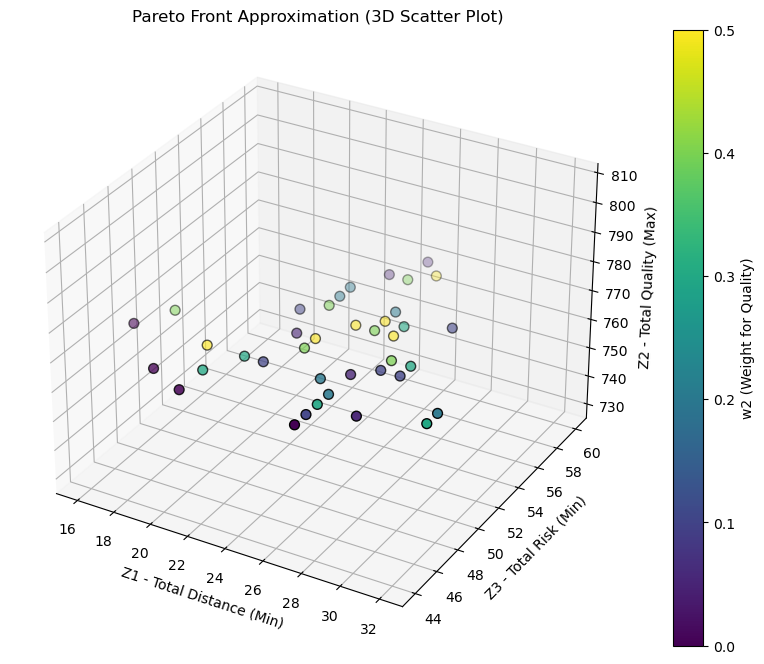

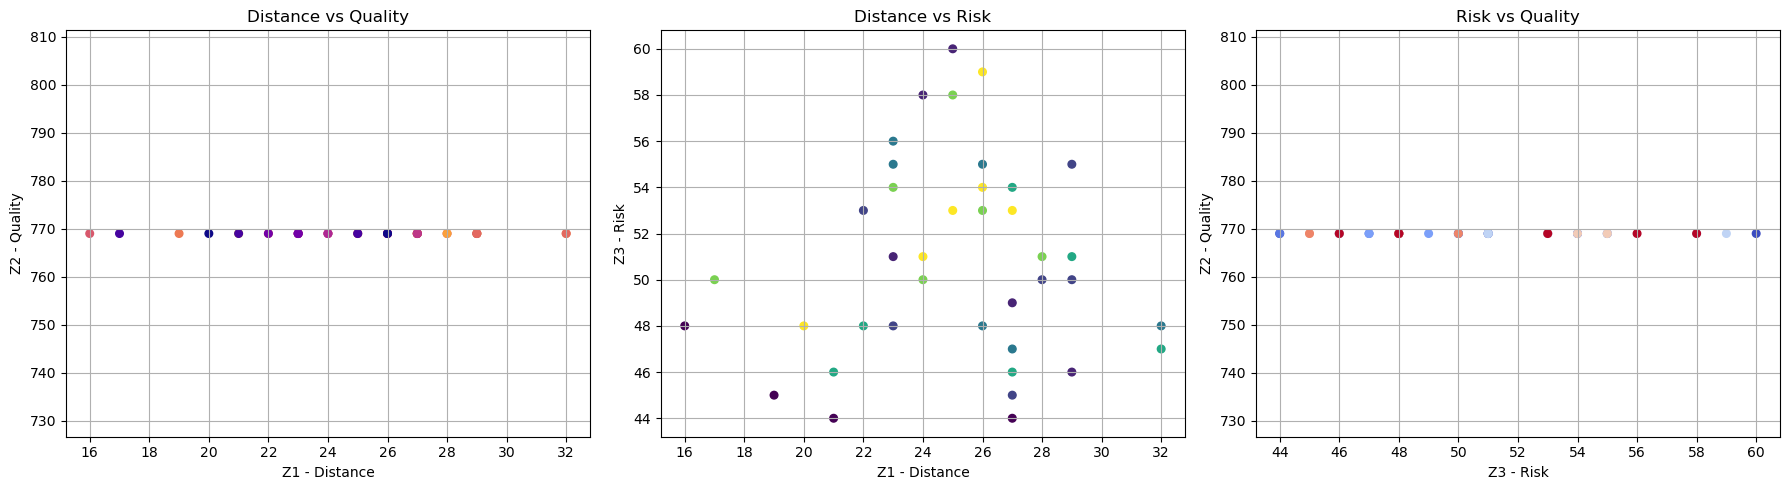


--- Analysis ---
1. Trade-offs: ...

2. Extreme Solutions:
          Z1     Z2    Z3
min_Z1  16.0  769.0  48.0
max_Z2  26.0  769.0  60.0
min_Z3  25.0  769.0  44.0

3. Balanced Solution:
   - Candidate near w=(1/3, 1/3, 1/3) (Weights: 0.40, 0.30, 0.30):
     Z1=22.00, Z2=769.00, Z3=48.00

4. Sensitivity (Example: Risk 2x more important):
   - Candidate nearest to w=(0.25, 0.25, 0.5) (Weights: 0.20, 0.30, 0.50):
     Z1=29.00, Z2=769.00, Z3=51.00

5. Route Visualization: ...


In [10]:
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # For 3D plotting
import numpy as np
import io # To read the string data like a file
import csv # To parse the CSV data

# --- Data Definition ---

# Locations (0 = Depot)
N = list(range(10))
C = list(range(1, 10))
num_nodes = len(N)

# Teams (Vehicles)
M = 2 # ASSUMPTION: 2 teams
V = list(range(M))

# --- Distance Matrix D[i,j] ---
# Data provided by the user (from cost_matrix_10_nodes_1.5_spread.csv content)
csv_data = """0,1,2,3,4,5,6,7,8,9
0,3,1,3,2,2,5,3,1,2
3,0,4,2,3,3,5,1,2,3
1,4,0,3,2,2,5,3,2,2
3,2,3,0,1,2,3,3,2,2
2,3,2,1,0,1,3,3,2,1
2,3,2,2,1,0,3,4,2,0
5,5,5,3,3,3,0,6,5,4
3,1,3,3,3,4,6,0,1,4
1,2,2,2,2,2,5,1,0,2
2,3,2,2,1,0,4,4,2,0
"""

# Parse the CSV data string
parsed_distances = []
# Use io.StringIO to treat the string as a file
data_io = io.StringIO(csv_data)
reader = csv.reader(data_io)
header = next(reader) # Skip the header row (0,1,2,...)

for i, row in enumerate(reader):
    if i >= num_nodes: # Stop if there are more rows than expected nodes
        print(f"Warning: CSV data has more rows ({i+1}) than nodes ({num_nodes}). Ignoring extra rows.")
        break
    # Convert row elements to integers
    try:
        parsed_distances.append([int(val) for val in row])
    except ValueError as e:
        print(f"Error parsing row {i+1}: {row}. Ensure all values are integers. Error: {e}")
        # Handle error - exit or use default matrix maybe
        raise # Re-raise the error to stop execution

if len(parsed_distances) != num_nodes:
     raise ValueError(f"Error: Parsed distance matrix has {len(parsed_distances)} rows, expected {num_nodes}.")
if any(len(row) != num_nodes for row in parsed_distances):
    raise ValueError(f"Error: Not all rows in parsed distance matrix have {num_nodes} columns.")


# Convert to dictionary format for Pyomo
D = {}
for i in range(num_nodes):
    for j in range(num_nodes):
        D[i, j] = parsed_distances[i][j]

# Optional: Verify the matrix looks correct
# print("Parsed Distance Matrix (snippet):")
# print(f"D(0,1) = {D.get((0,1), 'N/A')}, D(1,0) = {D.get((1,0), 'N/A')}")
# print(f"D(5,9) = {D.get((5,9), 'N/A')}, D(9,5) = {D.get((9,5), 'N/A')}")
# print(f"D(0,0) = {D.get((0,0), 'N/A')}")


# Quality Data q[i] (Table 5)
Q_data = {1: 85, 2: 92, 3: 78, 4: 90, 5: 82, 6: 88, 7: 95, 8: 75, 9: 84}
Q = {i: Q_data.get(i, 0) for i in C} # Quality is 0 for depot

# Risk Data r[i,j] (Table 6 + default 5)
R_raw = { # From Table 6 (add reverse arcs manually if needed)
    (0, 1): 3, (1, 0): 3, (0, 2): 2, (2, 0): 2, (0, 3): 4, (3, 0): 4,
    (0, 4): 5, (4, 0): 5, (0, 5): 6, (5, 0): 6, (0, 6): 3, (6, 0): 3,
    (0, 7): 2, (7, 0): 2, (0, 8): 4, (8, 0): 4, (0, 9): 5, (9, 0): 5,
    (2, 8): 9, (8, 2): 9, (2, 9): 8, (9, 2): 8, (3, 4): 5, (4, 3): 5,
    (4, 9): 7, (9, 4): 7, (5, 6): 7, (6, 5): 7, (8, 9): 7, (9, 8): 7,
    # Add other pairs mentioned if they exist
}
DEFAULT_RISK = 5
R = {}
for i in N:
    for j in N:
        if i == j:
            R[i, j] = 0
        else:
            R[i, j] = R_raw.get((i, j), DEFAULT_RISK)
# print("Risk Matrix:", R)


# --- Helper Function to Create and Solve Model ---
# (Rest of the solve_inspection_route function remains the same as before)
def solve_inspection_route(weights=None, objective_sense=None):
    # ... (function definition as in the previous response) ...
    model = pyo.ConcreteModel(name="Inspection_Routing_MOO")

    # --- Sets ---
    model.N = pyo.Set(initialize=N) # All nodes
    model.C = pyo.Set(initialize=C) # Customer nodes
    model.V = pyo.Set(initialize=V) # Vehicles/Teams

    # --- Parameters ---
    # model.d is now initialized using the parsed 'D' dictionary
    model.d = pyo.Param(model.N, model.N, initialize=D)
    model.q = pyo.Param(model.C, initialize=Q)
    model.r = pyo.Param(model.N, model.N, initialize=R)
    model.num_nodes = num_nodes

    # --- Variables ---
    # ... (variables definition same as before) ...
    model.x = pyo.Var(model.N, model.N, model.V, domain=pyo.Binary)
    model.y = pyo.Var(model.C, domain=pyo.Binary)
    model.u = pyo.Var(model.N, model.V, domain=pyo.NonNegativeReals, bounds=(0, model.num_nodes))


    # --- Objective Function Expressions ---
    # ... (objective definitions same as before) ...
    def z1_dist_rule(model):
        return sum(model.d[i, j] * model.x[i, j, k] for i in model.N for j in model.N for k in model.V if i != j)
    model.Z1_Dist = pyo.Expression(rule=z1_dist_rule)

    def z2_qual_rule(model):
        return sum(model.q[i] * model.y[i] for i in model.C)
    model.Z2_Qual = pyo.Expression(rule=z2_qual_rule)

    def z3_risk_rule(model):
        return sum(model.r[i, j] * model.x[i, j, k] for i in model.N for j in model.N for k in model.V if i != j)
    model.Z3_Risk = pyo.Expression(rule=z3_risk_rule)


    # --- Constraints ---
    # ... (constraints definitions same as before) ...
    # Ensure x[i,i,k] = 0
    def no_self_loops(model, i, k):
        return model.x[i, i, k] == 0
    model.NoSelfLoops = pyo.Constraint(model.N, model.V, rule=no_self_loops)

    # Each vehicle leaves depot 0 exactly once
    def leave_depot_rule(model, k):
        return sum(model.x[0, j, k] for j in model.C) == 1
    model.LeaveDepot = pyo.Constraint(model.V, rule=leave_depot_rule)

    # Each vehicle returns to depot 0 exactly once
    def return_depot_rule(model, k):
        return sum(model.x[i, 0, k] for i in model.C) == 1
    model.ReturnDepot = pyo.Constraint(model.V, rule=return_depot_rule)

    # Link y[i] (visited) to x[j,i,k] (entering i)
    def link_y_rule(model, i):
        # If node i is visited (y[i]=1), exactly one arc across all vehicles must enter it.
        # If node i is not visited (y[i]=0), no arcs enter it.
        return sum(model.x[j, i, k] for j in model.N for k in model.V if j != i) == model.y[i]
    model.LinkY = pyo.Constraint(model.C, rule=link_y_rule)

    # Flow conservation per vehicle k at customer node i
    def flow_conservation_rule(model, i, k):
        # Flow into node i by vehicle k == Flow out of node i by vehicle k
        return sum(model.x[j, i, k] for j in model.N if j != i) == sum(model.x[i, j, k] for j in model.N if j != i)
    model.FlowConservation = pyo.Constraint(model.C, model.V, rule=flow_conservation_rule)

    # opción A: una sola visita global
    def visit_once_rule(model, i):
        return sum(model.x[j, i, k] for j in model.N for k in model.V if j != i) == 1
    model.VisitOnce = pyo.Constraint(model.C, rule=visit_once_rule)


    # Subtour Elimination (MTZ style adapted)
    def subtour_elim_rule(model, i, j, k):
        if i == 0 or j == 0 or i == j:
            return pyo.Constraint.Skip
        M_val = model.num_nodes
        return model.u[j, k] >= model.u[i, k] + 1 - M_val * (1 - model.x[i, j, k])
    model.SubtourElim = pyo.Constraint(model.N, model.N, model.V, rule=subtour_elim_rule)

    # Force u[i,k] bounds based on whether node i is visited by vehicle k
    def enforce_u_lower_bound(model, i, k):
         if i == 0: return pyo.Constraint.Skip
         # If node i is visited by k (sum(x[j,i,k]) > 0), then u[i,k] >= 1
         return model.u[i, k] >= 1 * sum(model.x[j, i, k] for j in model.N if j != i)
    model.EnforceULower = pyo.Constraint(model.C, model.V, rule=enforce_u_lower_bound)

    def enforce_u_upper_bound(model, i, k):
        if i == 0: return pyo.Constraint.Skip
         # If node i is visited by k, u[i,k] <= num_nodes. If not visited, u[i,k] <= 0.
        return model.u[i, k] <= model.num_nodes * sum(model.x[j, i, k] for j in model.N if j != i)
    model.EnforceUUpper = pyo.Constraint(model.C, model.V, rule=enforce_u_upper_bound)

    # --- Define Objective based on input ---
    # ... (objective setting logic same as before) ...
    if weights is not None:
        if 'z_ranges' not in weights:
             raise ValueError("z_ranges (min/max for Z1, Z2, Z3) must be in weights dict for normalization")
        z_ranges = weights['z_ranges']
        w1, w2, w3 = weights['w1'], weights['w2'], weights['w3']
        z1_range = (z_ranges['z1_max'] - z_ranges['z1_min']) + 1e-9
        z2_range = (z_ranges['z2_max'] - z_ranges['z2_min']) + 1e-9
        z3_range = (z_ranges['z3_max'] - z_ranges['z3_min']) + 1e-9
        z1_norm = (model.Z1_Dist - z_ranges['z1_min']) / z1_range
        z2_norm = (z_ranges['z2_max'] - model.Z2_Qual) / z2_range # Inverted for maximization
        z3_norm = (model.Z3_Risk - z_ranges['z3_min']) / z3_range
        print(f"Setting weighted objective: w1={w1:.2f}, w2={w2:.2f}, w3={w3:.2f}")
        model.WeightedObj = pyo.Objective(expr= w1 * z1_norm + w2 * z2_norm + w3 * z3_norm, sense=pyo.minimize)
    elif objective_sense is not None:
        sense, obj_index = objective_sense
        if obj_index == 1:   model.Obj = pyo.Objective(expr=model.Z1_Dist, sense=sense)
        elif obj_index == 2: model.Obj = pyo.Objective(expr=model.Z2_Qual, sense=sense)
        elif obj_index == 3: model.Obj = pyo.Objective(expr=model.Z3_Risk, sense=sense)
        else: raise ValueError("Invalid objective_index")
    else: raise ValueError("Must specify either weights or objective_sense")


    # --- Solve ---
    # ... (solver call same as before) ...
    solver = pyo.SolverFactory('glpk')
    solver.options['tmlim'] = 180
    try:
        results = solver.solve(model, tee=False)
        if results.solver.termination_condition == pyo.TerminationCondition.optimal or \
           results.solver.termination_condition == pyo.TerminationCondition.feasible:
            z1_value = pyo.value(model.Z1_Dist)
            z2_value = pyo.value(model.Z2_Qual)
            z3_value = pyo.value(model.Z3_Risk)
            print(f"Solve Status: {results.solver.termination_condition}, Z1={z1_value:.2f}, Z2={z2_value:.2f}, Z3={z3_value:.2f}")
            return results.solver.termination_condition, z1_value, z2_value, z3_value, model
        else:
            print(f"Solver failed with status: {results.solver.termination_condition}")
            return results.solver.termination_condition, None, None, None, None
    except Exception as e:
        print(f"An error occurred during solve: {e}")
        return 'error', None, None, None, None



# --- Step 1: Find Objective Ranges (Ideal/Nadir Points) ---
# (This part remains the same - it calls solve_inspection_route)
print("\n--- Finding Objective Ranges ---")
solution_points = {}
# ... (code to call solve_inspection_route for objectives 1, 2, 3) ...
# Min Z1
status1, z1_1, z2_1, z3_1, _ = solve_inspection_route(objective_sense=(pyo.minimize, 1))
if status1 in [pyo.TerminationCondition.optimal, pyo.TerminationCondition.feasible]:
    solution_points['min_Z1'] = {'Z1': z1_1, 'Z2': z2_1, 'Z3': z3_1}
# Max Z2
status2, z1_2, z2_2, z3_2, _ = solve_inspection_route(objective_sense=(pyo.maximize, 2))
if status2 in [pyo.TerminationCondition.optimal, pyo.TerminationCondition.feasible]:
    solution_points['max_Z2'] = {'Z1': z1_2, 'Z2': z2_2, 'Z3': z3_2}
# Min Z3
status3, z1_3, z2_3, z3_3, _ = solve_inspection_route(objective_sense=(pyo.minimize, 3))
if status3 in [pyo.TerminationCondition.optimal, pyo.TerminationCondition.feasible]:
     solution_points['min_Z3'] = {'Z1': z1_3, 'Z2': z2_3, 'Z3': z3_3}

# Check if all solutions were found and define z_ranges
# ... (same logic as before for calculating z_ranges) ...
if len(solution_points) < 3:
    print("ERROR: Could not find optimal solutions for all single objectives. Cannot proceed with normalization.")
    z_ranges = {'z1_min': 10, 'z1_max': 100, 'z2_min': 100, 'z2_max': 800, 'z3_min': 10, 'z3_max': 100} # Dummy
    print("Using DUMMY ranges for objectives.")
else:
    df_ranges = pd.DataFrame(solution_points).T
    print("\nSingle Objective Solution Points:")
    print(df_ranges)
    z_ranges = {
        'z1_min': df_ranges['Z1'].min(), 'z1_max': df_ranges['Z1'].max(),
        'z2_min': df_ranges['Z2'].min(), 'z2_max': df_ranges['Z2'].max(),
        'z3_min': df_ranges['Z3'].min(), 'z3_max': df_ranges['Z3'].max(),
    }
    print("\nObjective Ranges for Normalization:")
    print(z_ranges)


# --- Step 2: Weighted Sum Method ---
# (This part remains the same - it calls solve_inspection_route with weights)
print("\n--- Running Weighted Sum Method ---")
pareto_points = []
# ... (code to generate weights and loop through them, calling solve_inspection_route) ...
weight_step = 0.25
num_steps = int(1 / weight_step)

# generated_weights = []
# for i in range(num_steps + 1):
#     for j in range(num_steps - i + 1):
#         k = num_steps - i - j
#         w1 = i * weight_step
#         w2 = j * weight_step
#         w3 = k * weight_step
#         if abs(w1 + w2 + w3 - 1.0) < 1e-6:
#              generated_weights.append({'w1': w1, 'w2': w2, 'w3': w3, 'z_ranges': z_ranges})


grid = [0, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50]
generated_weights = []
for w1 in grid:
    for w2 in grid:
        w3 = 1 - w1 - w2
        if w3 >= 0: 
            generated_weights.append({'w1': w1, 'w2': w2, 'w3': w3,
                                      'z_ranges': z_ranges})



print(f"Generated {len(generated_weights)} weight combinations.")

for weights_dict in generated_weights:
    print(f"\nSolving for Weights: w1={weights_dict['w1']:.2f}, w2={weights_dict['w2']:.2f}, w3={weights_dict['w3']:.2f}")
    status, z1, z2, z3, solved_model = solve_inspection_route(weights=weights_dict)
    if status in [pyo.TerminationCondition.optimal, pyo.TerminationCondition.feasible] and z1 is not None:
        
        # ---------- VALIDACIÓN RÁPIDA DE RUTAS -------------
        for k in solved_model.V:
            route = [0]
            current = 0
            while True:
                # busca el siguiente nodo con x[current, j, k] = 1
                next_nodes = [j for j in solved_model.N
                              if pyo.value(solved_model.x[current, j, k]) > 0.5]
                if not next_nodes or next_nodes[0] == 0:
                    route.append(0)      # regresó al depósito
                    break
                current = next_nodes[0]
                route.append(current)
            print(f"Vehículo {k}: {route}")
        # ----------------------------------------------------
        
        
        pareto_points.append({
            'w1': weights_dict['w1'], 'w2': weights_dict['w2'], 'w3': weights_dict['w3'],
            'Z1_Dist': z1, 'Z2_Qual': z2, 'Z3_Risk': z3
        })
    else:
         print(f"Skipping weights due to solver status: {status}")


# --- Step 3: Analysis and Visualization ---
# (This part remains the same)
if not pareto_points:
    print("\nNo feasible solutions found for any weight combination.")
else:
    df_pareto = pd.DataFrame(pareto_points)
    df_pareto = df_pareto.drop_duplicates(subset=['Z1_Dist', 'Z2_Qual', 'Z3_Risk'])
    print("\n--- Pareto Front Approximation ---")
    print(df_pareto[['Z1_Dist', 'Z2_Qual', 'Z3_Risk']].round(2))

    # Plotting (3D Scatter)
    # ... (3D plotting code same as before) ...
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(df_pareto['Z1_Dist'], df_pareto['Z3_Risk'], df_pareto['Z2_Qual'],
                    c=df_pareto['w2'], cmap='viridis', s=50, edgecolors='k')
    ax.set_xlabel('Z1 - Total Distance (Min)')
    ax.set_ylabel('Z3 - Total Risk (Min)')
    ax.set_zlabel('Z2 - Total Quality (Max)')
    ax.set_title('Pareto Front Approximation (3D Scatter Plot)')
    plt.colorbar(sc, label='w2 (Weight for Quality)')
    plt.show()


    # Plotting (2D Projections)
    # ... (2D plotting code same as before) ...
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].scatter(df_pareto['Z1_Dist'], df_pareto['Z2_Qual'], c=df_pareto['w3'], cmap='plasma', s=30); axs[0].set_xlabel('Z1 - Distance'); axs[0].set_ylabel('Z2 - Quality'); axs[0].set_title('Distance vs Quality'); axs[0].grid(True)
    axs[1].scatter(df_pareto['Z1_Dist'], df_pareto['Z3_Risk'], c=df_pareto['w2'], cmap='viridis', s=30); axs[1].set_xlabel('Z1 - Distance'); axs[1].set_ylabel('Z3 - Risk'); axs[1].set_title('Distance vs Risk'); axs[1].grid(True)
    axs[2].scatter(df_pareto['Z3_Risk'], df_pareto['Z2_Qual'], c=df_pareto['w1'], cmap='coolwarm', s=30); axs[2].set_xlabel('Z3 - Risk'); axs[2].set_ylabel('Z2 - Quality'); axs[2].set_title('Risk vs Quality'); axs[2].grid(True)
    plt.tight_layout()
    plt.show()

    # --- Discussion Points ---
    # ... (Analysis discussion same as before) ...
    print("\n--- Analysis ---")
    print("1. Trade-offs: ...")
    print("\n2. Extreme Solutions:")
    if solution_points: print(df_ranges.round(2))
    print("\n3. Balanced Solution:")
    # ... (find candidate near equal weights) ...
    target_w_bal = np.array([1/3, 1/3, 1/3])
    distances_bal = df_pareto.apply(lambda row: np.linalg.norm(np.array([row['w1'], row['w2'], row['w3']]) - target_w_bal), axis=1)
    if not distances_bal.empty:
        balanced_candidate = df_pareto.loc[distances_bal.idxmin()]
        print(f"   - Candidate near w=(1/3, 1/3, 1/3) (Weights: {balanced_candidate['w1']:.2f}, {balanced_candidate['w2']:.2f}, {balanced_candidate['w3']:.2f}):")
        print(f"     Z1={balanced_candidate['Z1_Dist']:.2f}, Z2={balanced_candidate['Z2_Qual']:.2f}, Z3={balanced_candidate['Z3_Risk']:.2f}")

    print("\n4. Sensitivity (Example: Risk 2x more important):")
    # ... (find candidate near target weights) ...
    target_w_sens = np.array([0.25, 0.25, 0.5])
    distances_sens = df_pareto.apply(lambda row: np.linalg.norm(np.array([row['w1'], row['w2'], row['w3']]) - target_w_sens), axis=1)
    if not distances_sens.empty:
        sensitivity_candidate = df_pareto.loc[distances_sens.idxmin()]
        print(f"   - Candidate nearest to w=(0.25, 0.25, 0.5) (Weights: {sensitivity_candidate['w1']:.2f}, {sensitivity_candidate['w2']:.2f}, {sensitivity_candidate['w3']:.2f}):")
        print(f"     Z1={sensitivity_candidate['Z1_Dist']:.2f}, Z2={sensitivity_candidate['Z2_Qual']:.2f}, Z3={sensitivity_candidate['Z3_Risk']:.2f}")

    print("\n5. Route Visualization: ...")